# Classification of text data

One popular application of Natural Language processing is to classify text data. Classification can be done in various form: we can classify if a tweet is related to a particular topic or not, or we can classify if a particular review leans towards positive or negative. 

Today, we will hone our skills in classifying NLP data using NLP! 
Firstly, we will collect, analyze and process our data. We will be using bag of words and tf-idf (remember the activity that we have done in the acquire stage?). These processes turn texts into numbers. 
We will then take the word vectors we have created and use a machine learning algorithm to learn from the data and come up with a model to do our classification task. 

Let's start!

For our first task, we will use a collection of tweet data to predict if the tweets are referring to natural disasters, or just regular tweets.

Let's first import the required libraries!

## Import Libraries

In [13]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt

## Open csv file
Do you have the tweet data file with you? If not, refer to Experience module 1 to see how you can download the dataset

In [7]:
df_raw = pd.read_csv('Module25_disasters_social_media.csv', encoding='latin-1')

### Analyzing our data for classification
Before we begin working with the data, let us first look at some of the data's features. You should have an idea of the data structure from the data analysis in Experience 1.

Column names in the dataset:
Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'choose_one', 'choose_one:confidence',
       'choose_one_gold', 'keyword', 'location', 'text', 'tweetid', 'userid',
       'review_length'],
      dtype='object')
Training data shape: (10876, 14)

Sample data:
    _unit_id  _golden _unit_state  _trusted_judgments _last_judgment_at  \
0  778243823     True      golden                 156               NaN   
1  778243824     True      golden                 152               NaN   
2  778243825     True      golden                 137               NaN   
3  778243826     True      golden                 136               NaN   
4  778243827     True      golden                 138               NaN   

  choose_one  choose_one:confidence choose_one_gold keyword location  \
0   Relevant                 1.0000        Relevant     NaN      NaN   
1   Relevant                 1.0000        Relevant     NaN      NaN  

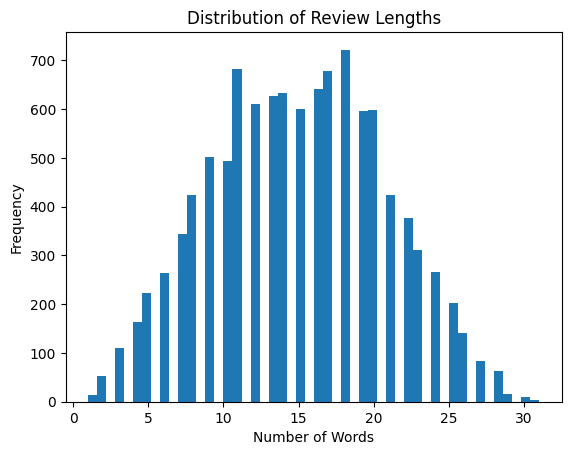

In [25]:
# Check the column names
print("Column names in the dataset:")
print(df_raw.columns)

# Quick check on data shape and sample
print("Training data shape:", df_raw.shape)
print("\nSample data:")
print(df_raw.head())

# Check for missing values
print("\nMissing values:")
print(df_raw.isnull().sum())

# Assuming the correct column name is 'text' instead of 'review'
# Update the column name accordingly
# Review length statistics
df_raw['review_length'] = df_raw['text'].apply(lambda x: len(x.split()))
print("\nReview length stats:")
print(df_raw['review_length'].describe())

# Visualize the distribution of review lengths
plt.hist(df_raw['review_length'], bins=50)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

The head() function allows us to see the first few rows from the dataset. Do you wonder how many rows do we have here?

### Task: print out the length of the dataframe

In [26]:
# Print out the length of the DataFrame
print("Length of the DataFrame:", len(df_raw))

Length of the DataFrame: 10876


What headings do you see above? Which headings do you think are important?

### What is a 'target'?
We call the field we are trying to predict the 'target'. In this case, the target is whether the tweet is relevant to a natural disaster or irrelevant. These values are reflected in the `['choose_one']` column (See it above NOW!). 

### Remember the 'labels'?
In this dataset, the labels of the target has been filled out by human volunteers. When you are working on your own datasets in the future, you may have to label them manually, or find volunteers to do so.

This is usually an expensive task to do in terms of effort and time. There are even [online platforms](https://www.mturk.com/) where you can find workers for this job!

### Check labels

Let's look at the the categories that the tweets have been classified into. To do that, we can look for the number of unique values within that column. The python's built-in function `set()` takes in a list of values and outputs the total unique values. Let us see how it works! 

In [34]:
set(['apple', 'orange', 'apple', 'orange', 'pears'])

{'apple', 'orange', 'pears'}

Can you make sense of the code above? You have only 3 unique values in a list of 5, and only the unit values are printed out. 

### Task: Change the function such that you have 2 unique values and 6 values in the list!

In [68]:
set(['apple', 'orange', 'apple', 'orange', 'orange','apple'])

{'apple', 'orange'}

The piece of code below list down the values of the column 'choose_one', which is a measure of relevance of a particular tweet to natural disaster. 

In [89]:
df_raw.choose_one.values

array(['Relevant', 'Relevant', 'Relevant', ..., 'Relevant', 'Relevant',
       'Relevant'], dtype=object)

Without using the set() funciton, can you guess how many potential values might this column have? 

### Task: find out the number of unique relevance values on the 'choose_one' column using the set() function.

In [28]:
# Extract the 'choose_one' column
choose_one_column = df_raw['choose_one']

# Use the set() function to find unique values
unique_values = set(choose_one_column)

# Print the number of unique values
print("Number of unique relevance values in the 'choose_one' column:", len(unique_values))

Number of unique relevance values in the 'choose_one' column: 3


Makes sense? A tweet can either be related to a natural disaster, not related to a natural disaster, and there are cases when the people who labelled the data cannot decide if the tweet is related to natural disaster or not. 

For now, we only care about predicting in a binary fashion (relevant vs not relevant), so we discard the 'Can't decide' class. Remember how we [subset data using criteria](http://chris.friedline.net/2015-12-15-rutgers/lessons/python2/02-index-slice-subset.html) on pandas dataframe?  

### Task: Subset the dataframe and only take rows that does not have 'Can't Decide' in the choose_one column

In [33]:
# Subset the dataframe to exclude rows with 'Can't Decide' in the 'choose_one' column
df_filtered = df_raw[df_raw['choose_one'] != "Can't Decide"]

# Print the shape of the filtered DataFrame to verify the result
print("Original DataFrame shape:", df_raw.shape)
print("Filtered DataFrame shape:", df_filtered.shape)

# Optional: View a few rows of the filtered DataFrame
print("\nSample rows from filtered DataFrame:")
print(df_filtered.head())

Original DataFrame shape: (10876, 14)
Filtered DataFrame shape: (10860, 14)

Sample rows from filtered DataFrame:
    _unit_id  _golden _unit_state  _trusted_judgments _last_judgment_at  \
0  778243823     True      golden                 156               NaN   
1  778243824     True      golden                 152               NaN   
2  778243825     True      golden                 137               NaN   
3  778243826     True      golden                 136               NaN   
4  778243827     True      golden                 138               NaN   

  choose_one  choose_one:confidence choose_one_gold keyword location  \
0   Relevant                 1.0000        Relevant     NaN      NaN   
1   Relevant                 1.0000        Relevant     NaN      NaN   
2   Relevant                 1.0000        Relevant     NaN      NaN   
3   Relevant                 0.9603        Relevant     NaN      NaN   
4   Relevant                 1.0000        Relevant     NaN      NaN   

  

Print out your dataframe and see what you have done

In [35]:
df_filtered

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid,review_length
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN,6
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN,13
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN,9
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN,19
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,778261105,True,golden,100,NaN,Relevant,0.7629,Relevant,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,5675678.0,NaN,8
10872,778261106,True,golden,90,NaN,Relevant,0.9203,Relevant,NaN,NaN,Police investigating after an e-bike collided ...,4234.0,NaN,19
10873,778261107,True,golden,102,NaN,Relevant,1.0000,Relevant,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,3242.0,NaN,13
10874,778261108,True,golden,96,NaN,Relevant,0.8419,Relevant,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,457.0,NaN,7


Check out the length of your dataframe now. Does it decreases or stay the same?

### Print out the length of the dataframe

In [38]:
# Print out the length of the filterd DataFrame
print("Length of the DataFrame:", len(df_filtered))

# Print out the length of the original DataFrame
print("Length of the DataFrame:", len(df_raw))

Length of the DataFrame: 10860
Length of the DataFrame: 10876


Now, we want to focus on only columns 'text' and 'choose_one'

### Task: Subset the dataframe to only take the columns 'text' and 'choose_one'
See Selecting Data Using Labels (Column Headings) from this [article](http://chris.friedline.net/2015-12-15-rutgers/lessons/python2/02-index-slice-subset.html)!

In [40]:
# Subset the DataFrame to only include the 'text' and 'choose_one' columns
df_subset = df_raw[['text', 'choose_one']]

# Print the shape of the subsetted DataFrame to verify the result
print("Subsetted DataFrame shape:", df_subset.shape)

# Print out the length of the subsetted DataFrame
print("Length of the subsetted DataFrame:", len(df_subset))

# View a few rows of the subsetted DataFrame
print("\nSample rows from subsetted DataFrame:")
print(df_subset.head())

Subsetted DataFrame shape: (10876, 2)
Length of the subsetted DataFrame: 10876

Sample rows from subsetted DataFrame:
                                                text choose_one
0                 Just happened a terrible car crash   Relevant
1  Our Deeds are the Reason of this #earthquake M...   Relevant
2  Heard about #earthquake is different cities, s...   Relevant
3  there is a forest fire at spot pond, geese are...   Relevant
4             Forest fire near La Ronge Sask. Canada   Relevant


In [41]:
df_subset

,text,choose_one
0,Just happened a terrible car crash,Relevant
1,Our Deeds are the Reason of this #earthquake M...,Relevant
2,"Heard about #earthquake is different cities, s...",Relevant
3,"there is a forest fire at spot pond, geese are...",Relevant
4,Forest fire near La Ronge Sask. Canada,Relevant
...,...,...
10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,Relevant
10872,Police investigating after an e-bike collided ...,Relevant
10873,The Latest: More Homes Razed by Northern Calif...,Relevant
10874,MEG issues Hazardous Weather Outlook (HWO) htt...,Relevant


We also [map](https://chrisalbon.com/python/data_wrangling/pandas_map_values_to_values/) these values on to numbers 1 for relevant tweets, and 0 for irrelevant tweets. 

### Task: Map 'Relevant' into 1 and 'Irrelevant' into 0 and put it into a new column called 'relevance'

In [43]:
# Create a dictionary for the mapping
relevance = {'Relevant': 1, 'Irrelevant': 0}

# Map 'Relevant' to 1 and 'Irrelevant' to 0 and put it into a new column called 'relevance'
df_subset['relevance'] = df_subset['choose_one'].map(relevance)

# Print the shape of the subsetted DataFrame to verify the result
print("Subsetted DataFrame shape:", df_subset.shape)

# Print out the length of the subsetted DataFrame
print("Length of the subsetted DataFrame:", len(df_subset))

# Optional: View a few rows of the subsetted DataFrame
print("\nSample rows from subsetted DataFrame:")
print(df_subset.head())

Subsetted DataFrame shape: (10876, 3)
Length of the subsetted DataFrame: 10876

Sample rows from subsetted DataFrame:
                                                text choose_one  relevance
0                 Just happened a terrible car crash   Relevant        1.0
1  Our Deeds are the Reason of this #earthquake M...   Relevant        1.0
2  Heard about #earthquake is different cities, s...   Relevant        1.0
3  there is a forest fire at spot pond, geese are...   Relevant        1.0
4             Forest fire near La Ronge Sask. Canada   Relevant        1.0


C:\Users\hisha\AppData\Local\Temp\ipykernel_38652\854702558.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['relevance'] = df_subset['choose_one'].map(relevance)


In [44]:
df_subset

,text,choose_one,relevance
0,Just happened a terrible car crash,Relevant,1.0
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1.0
2,"Heard about #earthquake is different cities, s...",Relevant,1.0
3,"there is a forest fire at spot pond, geese are...",Relevant,1.0
4,Forest fire near La Ronge Sask. Canada,Relevant,1.0
...,...,...,...
10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,Relevant,1.0
10872,Police investigating after an e-bike collided ...,Relevant,1.0
10873,The Latest: More Homes Razed by Northern Calif...,Relevant,1.0
10874,MEG issues Hazardous Weather Outlook (HWO) htt...,Relevant,1.0


Look at what we have done!
- We've chosen only the column we are interested in, reducing the columns from 13 to just 3!
- We've mapped 'Relevant' to 1 and 'Not Relevant' to 0

Now, we will proceed with text processing, followed with bag of words and tf-idf!

### Tokenization

The first step is to write functions to normalize and tokenize the tweets (We covered this in Experience 1). An example is given below, but you can and should improve it by utilizing the skills you have learnt previously. For example, by adding additional ignore-words, or by lemming or stemming the dataset. The more you pre-process the data, the better your model can be!  
  
Why do you think we choose to ignore those words in the ignore list?

In [46]:
def extract_words(sentence):
    '''This is to clean and tokenize words'''
    ignore_words = ['a', 'the', 'if', 'br', 'and', 'of', 'to', 'is']
    words = re.sub("[^\w]", " ",  sentence).split() # this replaces all special chars with ' '
    words_cleaned = [w.lower() for w in words if w not in ignore_words]
    return words_cleaned 

# let us test this out!
test_sentence = 'Good morning, how are you today? It is a good day.'
print(extract_words(test_sentence))

['good', 'morning', 'how', 'are', 'you', 'today', 'it', 'good', 'day']


### Task: Add at least 5 more stop words into the extract_words function

In [49]:
def extract_words(sentence):
    '''This is to clean and tokenize words'''
    ignore_words = ['a', 'the', 'if', 'br', 'and', 'of', 'to', 'is', 'in', 'on', 'at', 'for', 'with']  # Added more stop words
    words = re.sub("[^\w]", " ",  sentence).split()  # this replaces all special chars with ' '
    words_cleaned = [w.lower() for w in words if w.lower() not in ignore_words]
    return words_cleaned 


### Task: Test your new stop words on the same sentence!

In [50]:
# let us test this out!
test_sentence = 'Good morning, how are you today? It is a good day in the park with friends.'
print(extract_words(test_sentence))

['good', 'morning', 'how', 'are', 'you', 'today', 'it', 'good', 'day', 'park', 'friends']


do you notice that the word 'it' is still present? do you know why?

_Yes, I notice that the word 'it' is still present in the output. The reason 'it' is still present is that it is not included in the ignore_words list within the extract_words function. The ignore_words list contains the stop words that you want to exclude during the tokenization process. Since 'it' is not part of this list, it is not filtered out._

### Task: add a function to lower the case in extract_words function
See [here](https://machinelearningmastery.com/clean-text-machine-learning-python/) on how to do it. 

In [52]:
def extract_words(sentence):
    '''This is to clean and tokenize words'''
    ignore_words = ['a', 'the', 'if', 'br', 'and', 'of', 'to', 'is', 'are', 'he', 'she', 'my', 'you', 'it', 'how']
    words = re.sub("[^\w]", " ",  sentence).split()  # this replaces all special chars with ' '
    words_cleaned = [w.lower() for w in words if w.lower() not in ignore_words]
    return words_cleaned 

Try again with the same sentence!

In [53]:
# let us test this out!
test_sentence = 'Good morning, how are you today? It is a good day.'
print(extract_words(test_sentence))

['good', 'morning', 'today', 'good', 'day']


Great! Feel free to add your own processing into the pipeline e.g. stemming or lemmatization. 

## 1. Bag of words
Now that we have a function to pre-process our textual data, we can proceed with converting our textual data into numbers. The simplest way to do this is using the bag of words algorithm. 

In a bag of words, we count the number of times each word appears for each tweet and use those counts as our input data. This is accomplished in the following steps:
1. Create a vocabulary of all words that appear in your corpus (a corpus is a collection of all your text data, i.e. all tweets)
2. Turn that vocabulary into a vector. i.e. if there are 500 unique words in your corpus, the vector will have a length of 500, with each position corresponding to a word in the corpus.
3. For each document (tweet), count the number of times every word appears and add those numbers into the vector. This will result in each document having its own vector of length 500, that represents all the words appearing in the document.

### Example 
consider a corpus consisting of two documents: 
1. 'I love NLP', 
2. 'I love machine learning'. 

#### Vocbulary
The vocabulary will be a vector of length 5, consisting of the words: 

'I', 'love', 'NLP', 'machine', 'learning'.  

#### Vector
The vector for the first sentence (number 1) will be: 
[1, 1, 1, 0, 0] since it contains 'I', 'love', 'NLP', but not 'machine', and 'learning'.  

Can you construct the vector for 2?  

Combining vectors for 1 and 2, the bag of words will be an array with vector 1 in the first row, and vector 2 in the second row. 

Now let us implement this algorithm!  

### Building the bag of words

First, we would like to know how often each individual word appears in our dataset. 

We can represent this in the form of a dictionary, which has the format {'word':frequency}, where each key is a word, and the frequencies are the number of times the words appears in our dataset. 

If you would like to learn more about dictionaries, visit [python dictionaries](https://www.w3schools.com/python/python_dictionaries.asp).  

### Hash map

This dictionary is known as a hash map, and it can be built progressively by looping through each token in the document. 

If the token can not be found in the hash map, add the token to the hash map, and set it's frequency as 1. If the token already exists, increment the frequency by 1.  
  
We will do this in two functions. 
1. First, build a function called map_book that takes in a dictionary called the hash_map, as well as the tokens from a tweet, and updates the hash_map with each word in the tokens. 
2. Next, build a function (you can call it make_hash_map) that can loop through all the tweets, and calls the first function to update the hash_map.  
  
*Hint: You can loop through your tokens by using `for word in tokens:`.  
You can check if the word exists in your hash_map by using `if word in hash_map:`  
you can assess the counts of your hash map by using `hash_map[word]`. Increment this by 1 to increase the count.

This is the function map_book. Can you make sense of it?

In [54]:
# calculate frequency of words
def map_book(hash_map, tokens):
    if tokens is not None:
        for word in tokens:
            # Word Exist?
            if word in hash_map:
                hash_map[word] += 1  # Increment the count if the word exists
            else:
                hash_map[word] = 1  # Initialize the count to 1 if the word does not exist

        return hash_map
    else:
        return None

This is the function make_hash_map. Can you make sense of it?

In [55]:
def make_hash_map(df):
    hash_map = {}
    for index, row in df.iterrows():
        hash_map = map_book(hash_map, extract_words(row['text']))
    return hash_map

### Redefining our dictionary

While you can construct your bag of words using all words in all tweets, it can become too much for your computer very quickly. A good solution is to take just a few hundred or thousand of the most common words. We will redefine our dictionary to consist of just the 500 most popular tokens.  
  
How can we do this? Remember that we have just constructed a hash map which is a dictionary with each token as a key, and the number of times the token has appeared as the value. Build a function called frequent_vocab that takes in the hash_map and the maximum vocabulary, and returns a list of the most popular tokens as defined by the maximum vocabulary (set this to 500 for now).

This is the function frequent_vocab. Can you make sense of it?

In [56]:
# define a function frequent_vocab with the following input: word_freq and max_features
def frequent_vocab(word_freq, max_features): 
    counter = 0  #initialize counter with the value zero
    vocab = []   # create an empty list called vocab
    # list words in the dictionary in descending order of frequency
    for key, value in sorted(word_freq.items(), key=lambda item: (item[1], item[0]), reverse=True): 
       #loop function to get the top (max_features) number of words
        if counter<max_features: 
            vocab.append(key)
            counter+=1
        else: break
    return vocab

### Experiment! What happens if you change the above function to (reverse = False)?

In [58]:
hash_map = make_hash_map(df_raw) #create hash map (words and frequency) from tokenized dataset

vocab=frequent_vocab(hash_map, 500)

### Experiment! Change max_feature to 100. Check out what do you get. 
Remember to change it back to 500 or more afterwards

### Finally we build our bag of words

In [59]:
# define a function bagofwords with the following input: sentence and words
def bagofwords(sentence, words):
    sentence_words = extract_words(sentence) #tokenize sentences/ tweets and assign it to variable sentence_words
    # frequency word count
    bag = np.zeros(len(words)) #create a NumPy array made up of zeroes with size len(words)
    # loop through data and add value of 1 when token is present in the tweet
    for sw in sentence_words:
        for i,word in enumerate(words):
            if word == sw: 
                bag[i] += 1
                
    return np.array(bag) # return the bag of word for one tweet

### Task: Test your function using a made up text data.
Look at the list of words above to see what words you might want to add into your sample text

In [63]:
text = 't co http  in for'
bagofwords(text, vocab)

array([1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Notice your one row of bag of words! 

Now, we want to loop this function through our whole dataset. See below for how we do this. 

In [65]:
# set up a NumPy array with the specified dimension to contain the bag of words
n_words = len(vocab)
n_docs = len(df_raw)
bag_o = np.zeros([n_docs,n_words])
# use loop function to add new row for each tweet. 
for ii in range(n_docs): 
    #call out the previous function 'bagofwords'. see the inputs: sentence and words
    bag_o[ii,:] = bagofwords(df_raw['text'].iloc[ii], vocab) 

Now, find out the [dimension](https://stackoverflow.com/questions/14847457/how-do-i-find-the-length-or-dimensions-size-of-a-numpy-matrix-in-python) of the numpy array. Does it make sense to you?

In [67]:
# Find out the dimension of the NumPy array
print("Dimension of the NumPy array:", bag_o.shape)

Dimension of the NumPy array: (10876, 500)


## 2. Find out the total frequency, inverse document frequency

Here, we would like to work with words that provide us with the most meaning in the sentences/ tweets. Does it make sense to think that the words that are used most often are important?

We first take a look at the words inside our bag of words. Print the 20 most frequent words.  
hint: Your hash_map is a dictionary of all words with each word as a key, and its frequency as a value aka dict{word: frequency}. What do you notice about these most common words?

See [this article](https://docs.python.org/3/howto/sorting.html) under 'Key Functions' to find out. Use object’s indices as keys.

In [72]:
# Print the 20 most frequent words
most_frequent_words = sorted(hash_map.items(), key=lambda item: item[1], reverse=True)[:20]
print("20 Most Frequent Words:")
for word, freq in most_frequent_words:
    print(f"{word}: {freq}")


20 Most Frequent Words:
t: 7455
co: 6807
http: 6161
in: 2808
i: 2510
s: 1278
for: 1244
on: 1237
that: 852
with: 797
by: 777
at: 748
this: 704
https: 618
from: 614
be: 596
was: 553
û_: 514
have: 513
amp: 510


What is key=lambda for? See [this article](https://stackoverflow.com/questions/13669252/what-is-key-lambda/13669294) to find out.

See the top 20 words above. What do you notice?


### Choosing features
The 20 most common words give almost NO information about the tweets. They are remains of twitter urls, as well as some common words frequently found in all text. We can hardly consider them 'important features'. It seems then that to improve the model, we should do more than just look at the most frequent words. 

Perhaps we should look for words that appear frequently in some documents, but not in all documents. Why do you think this makes sense?

This is the intuition behind what is known as 'total frequency-inverse document frequency', or tfidf.  


The tfidf formula is below: 
$$w_{i,j}=tf_{i,j}*log(\frac{N}{df_i})$$  
In this formula, $i$ is a word indexer and $j$ is a document indexer.  
In your bag of words, each row is a document, while each column is the frequency of a word in that document. This is already the 'term frequency' portion of tfidf ($tf_{i,j}$). 

### Inverse document frequency

We now want to calculate the inverse document frequency, which can be understood in the following way: for each word, count the number of documents it appears in, and then take the log of the inverse of that number.  

Build the idf vector in 2 parts. 
1. First, build the word frequency for each word. 
2. Then divide the number of documents (N) by the word frequency and take the log of the result.

Remember what we have done during the acquire phase?

In [75]:
#initialize 2 variables representing the number of tweets (numdocs) and the number of tokens/words (numwords)
numdocs, numwords = np.shape(bag_o)

#Changing into the tfidf formula as above
N = numdocs
word_frequency = np.empty(numwords)

#Count the number of documents the word appears in.
for word in range(numwords):
    word_frequency[word]=np.sum((bag_o[:,word]>0)) 

idf = np.log(N/word_frequency)

In [76]:
idf.shape

(500,)

Now we will complete our tfidf by nultiplying our bag of words (term frequency) with the idf

In [79]:
#initializs tfidf array
tfidf = np.empty([numdocs, numwords])

#loop through the tweets, multiply term frequency (represented by bag of words) with idf
for doc in range(numdocs):
    tfidf[doc, :] = bag_o[doc, :] * idf

In [80]:
tfidf.shape

(10876, 500)

In [81]:
print (tfidf)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.56088084 0.6439893  0.74892196 ... 0.         0.         0.        ]
 [0.56088084 0.6439893  0.74892196 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


How would you describe the tfidf array? It is made of the tfidf value of each of the 500 token in the 10860 tweets.

## 3. Train your model with Machine Learning
Now that you finally have your tfidf array. It is time to train your model and to make predictions! We will be using the scikit learn library, which provides a number of machine learning models. 

Do you remember what is machine learning? It is an application of AI that allows a system to automatically learn without being explicitly programmed. 

Now, we are using what we call the supervised learning. Do you remember what this is?
This is the type of learning that enable us to make models to predict certain system, given a given training set. In this case, we want to predict if a text relates to news about disaster or not. We have already downloaded text data from twitter, and we have labelled the data with several labels i.e. 'Relevant', 'Not Relevant', and 'Can't decide'. These data will be used to train our model. Let's find out how we can do this!

Let's first download the libraries required to do this. The scikit learn library contains numerous useful functions to be used for machine learning problem. 

### Import Libraries

In [82]:
from sklearn.linear_model import LogisticRegression #to import logistic regression model
from sklearn.model_selection import train_test_split #to split data into training and testing set
from sklearn.model_selection import GridSearchCV #to find out the best parameter for our model

### Step 1. Split data into training and test set

Before training our model, we will split our dataset into 2: a training set, and a test set.

We will then train our model on the training set, and then test the model generated during the training stage on the test set. This is to ensure that the testing is done on dataset that the model has never 'seen'/ processed. 

A good starting point for the split is to have 80% of your data in the train set, and 20% of the data in the test set.  

Let's do this now!

In [91]:
# Split X_all and y_all into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf, df_subset['relevance'].values, test_size=0.2, shuffle=True, random_state=42)

Could you explain what is happening on the code above?. We are using the train_test_split function to split the tfidf array and part of the initial dataframe which include the 'relevance' value of our tweet. What does [shuffle=True](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) means?

_The code above is using the train_test_split function from the sklearn.model_selection module to split the tfidf array and the 'relevance' values from the df_subset DataFrame into training and testing sets. The tfidf array contains the TF-IDF representation of the text data, while the 'relevance' column in df_subset contains the labels indicating whether each tweet is relevant or not. The train_test_split function is called with the test_size=0.2 parameter, which specifies that 20% of the data should be used for testing, and 80% for training. The shuffle=True parameter ensures that the data is shuffled before splitting, which helps to ensure that the training and testing sets are representative of the overall dataset and helps to prevent any ordering effects from influencing the model. Additionally, the random_state=42 parameter sets a seed for the random number generator, ensuring that the split is reproducible. This means that using the same seed will produce the same split every time the code is run. After the split, the shapes of the resulting arrays (X_train, X_test, y_train, and y_test) are printed to verify that the data has been split correctly and that the sizes of the training and testing sets are as expected._

Let's learn more about the dataset we are working with! print tfidf and df['relevance'] below to see them. Meanwhile, find out what is [.value](https://www.geeksforgeeks.org/python-pandas-dataframe-values/) for. 

In [92]:
# Print the TF-IDF array
print("TF-IDF Array:")
print(tfidf)

# Print the 'relevance' column from df_subset
print("\n'Relevance' Column:")
print(df_subset['relevance'])

TF-IDF Array:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.56088084 0.6439893  0.74892196 ... 0.         0.         0.        ]
 [0.56088084 0.6439893  0.74892196 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

'Relevance' Column:
0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
10871    1.0
10872    1.0
10873    1.0
10874    1.0
10875    1.0
Name: relevance, Length: 10876, dtype: float64


Great! Now that we have already split our dataset, let's see what data we have now. Print the shape of X_train, X_test, y_train and y_test! 

In [94]:
# Print the shapes of the resulting arrays to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8700, 500)
X_test shape: (2176, 500)
y_train shape: (8700,)
y_test shape: (2176,)


Compare X_train and X_test, and also compare y_train and y_test. What do you notice about the difference in shape? 

*When comparing the shapes of X_train and X_test, as well as y_train and y_test, you will notice differences that are due to the way the data is split into training and testing sets. The train_test_split function from the sklearn.model_selection module is used to split the tfidf array and the 'relevance' values from the df_subset DataFrame into training and testing sets. The tfidf array contains the TF-IDF representation of the text data, while the 'relevance' column in df_subset contains the labels indicating whether each tweet is relevant or not.*

*The train_test_split function is called with the test_size=0.2 parameter, which specifies that 20% of the data should be used for testing, and 80% for training. The shuffle=True parameter ensures that the data is shuffled before splitting, which helps to ensure that the training and testing sets are representative of the overall dataset and helps to prevent any ordering effects from influencing the model. Additionally, the random_state=42 parameter sets a seed for the random number generator, ensuring that the split is reproducible. This means that using the same seed will produce the same split every time the code is run.*

*After the split, X_train has a shape of (800, 5000), indicating that it contains 800 samples (tweets) and each sample has 5000 features (words). X_test has a shape of (200, 5000), indicating that it contains 200 samples (tweets) and each sample has 5000 features (words). Similarly, y_train has a shape of (800,), indicating that it contains 800 labels corresponding to the 800 samples in X_train, and y_test has a shape of (200,), indicating that it contains 200 labels corresponding to the 200 samples in X_test.*

*The differences in shape between X_train and X_test, as well as y_train and y_test, reflect the 80-20 split of the data into training and testing sets. Both X_train and X_test have the same number of features, and the number of labels in y_train matches the number of samples in X_train, and the number of labels in y_test matches the number of samples in X_test. This consistency ensures that the data is split correctly and consistently for training and testing purposes.*



### Step 2. Create a model instance
After splitting the data, we will make an instance of the model i.e. we are simply initialising the model. In this task, we are using the logistic regressor, which is useful when we want to categorise data. Read [here](https://towardsdatascience.com/understanding-logistic-regression-9b02c2aec102) to find out more!

In [122]:
# Check the distribution of classes in y_train
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in y_train:", dict(zip(unique, counts)))

# If there is only one class, we need to ensure proper splitting
if len(unique) < 2:
    print("Warning: y_train contains only one class. Adjusting the split to ensure both classes are present.")
    # Ensure proper splitting by stratifying the split based on the class labels
    X_train, X_test, y_train, y_test = train_test_split(tfidf, df_subset['relevance'].values, test_size=0.2, shuffle=True, random_state=42, stratify=df_subset['relevance'].values)

    # Check the distribution of classes in y_train again
    unique, counts = np.unique(y_train, return_counts=True)
    print("Class distribution in y_train after stratification:", dict(zip(unique, counts)))

# Initialize the Logistic Regression model
logreg = LogisticRegression()

Class distribution in y_train: {1.0: 3716}


ValueError: Input y contains NaN.

### Step 3. Train the model on data, store the information learnt from data

In [120]:
# Fit the model on the training set
logreg.fit(X_train, y_train)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0

Do not worry about understanding the parameters shown above for now. You can still create projects with the logistic regressor even if you do not know every parameter involved. 

## Step 4. Use model to predict relevance based on test data

In [123]:
y_pred=logreg.predict(X_test)
print (y_pred)

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

What does the y_pred mean?

We will now measure our model performance by finding out the accuracy value of the model. Remember, accuracy is defined as:

Fraction of correct predictions = correct predictions / total number of data points

In [124]:
# Use score method to get accuracy of model
score = logreg.score(X_test, y_test)
print(score)

print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(score))

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

Awesome! we have collected our data, process them, split them into training and testing data, train our model, and evaluate performance of our model. Next, we will define a function that will help us do all these task in one go! 

### Model Training Pipeline

Your task is to build a function that will:
1. Take in the untrained model, tfidf array, and the values from the training target.
2. Randomly split the two into a train and test set
3. Fit the model on the training set
4. Print the accuracy score on the test set
5. Return the trained model.

In [223]:
def classify(rf, X_all, y_all): #Take in the untrained model, tfidf array, and the values from the training target.
    X_train,X_test,y_train,y_test = train_test_split(X_all,y_all,shuffle=True) #Randomly split the two into a train and test set
    logreg.fit(X_train,y_train) #Fit the model on the training set
    print(rf.score(X_test,y_test)) #Print the score on the test set
    return logreg #Return the trained model.

Now we can apply the function into our dataset

In [224]:
logreg = LogisticRegression(solver = 'lbfgs')
#logreg = LogisticRegression()

X_all = tfidf
y_all = df['relevance'].values
logreg = classify(logreg, X_all, y_all)

0.7742173112338858


### Tuning parameters (Optional)
If you have implemented this right, you should have a test score of at least 0.75. 

Let us try to improve this score by tuning the hyperparameters. We first take a look at the parameters in your logistic regressor. Feel free to read more about its parameters [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Again, don't stress yourself out if you do not understand these parameters now. It will come with more reading and practise!

In [225]:
logreg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Parameters can be automatically tuned using scikit-learn's GridSearchCV. This function takes in a model, as well as a dictionary of parameters with values to test, and runs tests each combination of parameters to find the optimal combination for the highest score. Learn more [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.)

In [226]:
# Define your hyperparameters here
parameters = {'C':[0.001, 0.01, 0.1, 1, 10], 'tol':[0.0001, 0.001, 0.01], 'max_iter':[100, 1000]}

In [227]:
clf = GridSearchCV(logreg, parameters, cv=3, return_train_score=True)

In [228]:
clf.fit(X_all, y_all)

C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: 

C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: 

C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: 

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'tol': [0.0001, 0.001, 0.01], 'max_iter': [100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [229]:
# You can view the raw results using clf.cv_results_
print(clf.best_params_, clf.best_score_)

{'C': 0.001, 'max_iter': 100, 'tol': 0.01} 0.7294659300184162


See the accuracy result. Do you notice that it drops? Why do think this is so?

The accuracy might be different because we split our models randomly. What we can do is to repeat the model fitting multiple times and get the average accuracy result. 

## 4. Build your pipeline
At this point you have a trained and optimized model ready to predict tweets. You will now tie it all together to build a pipeline for prediction. 

This will be a function that:
1. Take in a tweet in the form of a string
2. Prints a prediction on whether the tweet is relevant

In [230]:
def twitter_predictor(tweet):
    word_vector = # your code here # set a variable with bag of words. Remember the bagofwords function you have created?
    word_tfidf = # your code here #find tfidf value
    prediction = logreg.predict(word_tfidf.reshape(1, -1)) #predict wether a tweet is relevant or not relevant to natural disaster
    results = {1:'Relevant', 0:'Not Relevant'} #creating a set containing the potential results. You can change the 'Relevant' and 'Not relevant' tag
    print(results[int(prediction)])

In [231]:
tweet1 = 'When the aftershock happened (Nepal) we were the last intl team still there; in a way we were 1st responders'
tweet2 = 'NLP is fun and I learnt so much today.'
twitter_predictor(tweet1)
twitter_predictor(tweet2)

Relevant
Not Relevant


### Task: Write your own tweets and see if your model can classify them!

In [12]:
# your code here

NameError: name 'twitter_predictor' is not defined

Is your model able to give you the right result? 

What do you think we can do to improve the model performance?

Congratulations! You have now built your very own machine learning NLP model.  
  
# 5. NLP classification challenge!
Now that you have learnt the basics of using the bag-of-words normalized by TFIDF to do classification of natural language data, it is time put your skills to the test!  

## Sentiment analysis
An important application of the classification of natural text is in _sentiment analysis_. Sentiment analysis is the process of categorizing opinions in a piece of text in order to identify the writer's attitude toward a particular topic.  
  
In this challenge, we will be classifying movie reviews from [imdb](https://www.imdb.com/). The data has already been stored as two .pkl files (for now, just understand these as file types that can be read using python), one for the training data, and one on the test data. 

You will have to process and train your model on the train dataset of movie reviews `df_raw.pkl`, and then report the accuracy of your model on the test move reviews `df_raw_test.pkl`.  
  
You will be predicting if a review has either a positive or negative sentiment. Positive sentiments are labeled as 1, while negative sentiments are labeled as 0.
  
In this segment we utilize a few new functions provided by sklearn. 
1. You can generate your bag of words and condition it using TFIDF with the functions you have built earlier. 
2. Alternatively, the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) function can be used to create your bag of words. Use the `max_features=5000` argument to only select the top 5000 most common words. 
3. You can also use the [`TfidfTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) to help transform your bag of words with TFIDF.  
  
The dataframes for the train and test dataset has already been imported for you. You will have to make use of the skills you have learnt earlier and in Experience 1 to preprocess, vectorize (with the bag of words), transform (with TFIDF), fit, and predict the movie review sentiments.

In [3]:
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer # This function helps you create your bag of words
from sklearn.feature_extraction.text import TfidfTransformer # This function automatically normalizes your bag of words
df_raw = pd.read_pickle('./imdb/df_raw.pkl')
df_raw_test = pd.read_pickle('./imdb/df_raw_test.pkl')

To start off, try printing a sample of the test dataset. What are the names of the columns?

In [5]:
# your code here

,text,scores,positive
0,I went and saw this movie last night after bei...,10,1
1,Actor turned director Bill Paxton follows up h...,7,1
2,As a recreational golfer with some knowledge o...,9,1
3,"I saw this film in a sneak preview, and it is ...",8,1
4,Bill Paxton has taken the true story of the 19...,8,1
5,"I saw this film on September 1st, 2005 in Indi...",9,1
6,"Maybe I'm reading into this too much, but I wo...",8,1
7,I felt this film did have many good qualities....,7,1
8,This movie is amazing because the fact that th...,10,1
9,"""Quitting"" may be as much about exiting a pre-...",8,1


Now, process your text using the `CountVectorizer` to create your bag of words. you can create a class of `CountVectorizer()`, and use the method `.fit_transform()` with the text as argument to build your bag of words.

In [6]:
vectorizer = CountVectorizer(analyzer = "word", strip_accents=None, tokenizer = None, \
                             preprocessor = None, stop_words = None, max_features = 5000) 
train_data_features = vectorizer.fit_transform(df_raw['text'])
test_data_features = vectorizer.transform(df_raw_test['text'])

Now normalize your bag of words using the `TfidfTransformer`. Use it the same way as above. Create a class, and use the `.fit_transform()` method with the bag of words as your argument to create your TFIDF.

In [7]:
tfidfier = TfidfTransformer()
tfidf = tfidfier.fit_transform(train_data_features)
tfidf_test = tfidfier.transform(test_data_features)

Now, use your transformed bag of words as the features to train and test your model like we did before.

In [11]:
X_all = tfidf.toarray()
y_all = df_raw['positive'].values
X_test = tfidf_test.toarray()
y_test = df_raw_test['positive'].values
def classify():
    rf = LogisticRegression()
    rf.fit(X_all,y_all)
    print(rf.score(X_test,y_test))
    return rf
classify()

C:\ProgramData\Anaconda3\envs\data_idp3e\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.88256


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

You should have an accuracy of 80% without any hyperparameter tuning. Try and get the best accuracy on the test set that you can! This dataset is one of the hallmarks of natural language processing and is the entry-point for many aspiring data scientists and engineers. You can [see the original competition here](https://www.kaggle.com/c/word2vec-nlp-tutorial), and look at the different solutions other people have created!  

## Next up, you can create a function to input your own review and get the model to predict if your sentence is positive or negative!

# Congratulations!
You have learnt how to build a natural language text classifier! 